In [1]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(sys.path[0], '..'))
sys.path.append(parent_dir)
from tools import ShiftedLegendrePolynomialBatch
import torch
from matplotlib import pyplot as plt

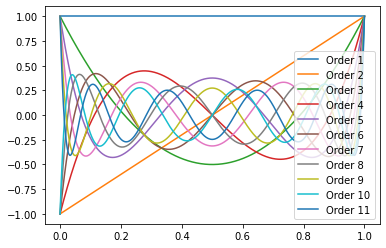

In [2]:
Legendre = ShiftedLegendrePolynomialBatch(max_order=10)
x_vals = torch.linspace(0,1,1000)
polynomials = Legendre(x_vals).detach().numpy()
for i in range(polynomials.shape[1]):
    plt.plot(x_vals, polynomials[:,i], label=f"Order {i+1}")
plt.legend()

In [11]:
polynomials.shape

(1000, 10)

In [7]:
def compare_derivatives(max_order):
    import matplotlib.pyplot as plt

    # Define maximum order
    # max_order = 5

    # Initialize the module
    legendre_batch = ShiftedLegendrePolynomialBatch(max_order=max_order)

    # Create input tensor x in [0,1] with requires_grad=True
    x = torch.linspace(0.001, 0.999, steps=1000, requires_grad=True)  # Shape: (100,)

    # Evaluate polynomials using the module
    P = legendre_batch(x)  # Shape: (100, 5)

    # Initialize a tensor to hold autograd derivatives
    autograd_derivatives = torch.zeros_like(P)

    # Compute derivatives via autograd
    for n in range(max_order):
        # Zero existing gradients
        if x.grad is not None:
            x.grad.zero_()
        
        # Select P_n(x), where n ranges from 0 to max_order-1
        Pn = P[:, n]  # Shape: (100,)

        # Compute gradients: dP_n/dx for each x
        # To compute element-wise gradients, set grad_outputs to ones
        grad_outputs = torch.ones_like(Pn)
        grads = torch.autograd.grad(
            outputs=Pn,
            inputs=x,
            grad_outputs=grad_outputs,
            retain_graph=True,
            create_graph=False
        )[0]  # Shape: (100,)

        # Store the gradients
        autograd_derivatives[:, n] = grads

    # Compute derivatives using the module's derivative method
    module_derivatives = legendre_batch.derivative(x)  # Shape: (100, 5)

    # Compare the derivatives
    difference = torch.abs(autograd_derivatives - module_derivatives)
    max_diff = difference.max().item()
    mean_diff = difference.mean().item()

    print(f"Maximum difference between autograd and module's derivatives: {max_diff:.6e}")
    print(f"Mean difference between autograd and module's derivatives: {mean_diff:.6e}")

    # Optionally, assert that the differences are within a tolerance
    tolerance = 1e-6
    if torch.all(difference < tolerance):
        print(f"\nAll derivative differences are below the tolerance of {tolerance}.")
    else:
        print(f"\nSome derivative differences exceed the tolerance of {tolerance}.")

    # Print a few sample differences
    print("\nSample differences (autograd - module):")
    for n in range(max_order):
        max_diff_n = difference[:, n].max().item()
        mean_diff_n = difference[:, n].mean().item()
        print(f"Order {n+1}: Max diff = {max_diff_n:.6e}, Mean diff = {mean_diff_n:.6e}")

    # Plot the derivatives for visual comparison
    for n in range(max_order):
        plt.figure(figsize=(8, 4))
        plt.plot(x.detach().numpy(), autograd_derivatives[:, n].detach().numpy(),
                 label='Autograd derivative', color='blue')
        plt.plot(x.detach().numpy(), module_derivatives[:, n].detach().numpy(),
                 '--', label='Module derivative', color='red')
        plt.title(f'Derivative Comparison for Order {n+1}')
        plt.xlabel('x')
        plt.ylabel(f'dP_{n+1}/dx')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()